## Gassmann fluid substitution and AVO 

#### Reproduce the figures 5, 7 and 8 from [Smith et al. (2003)](https://library.seg.org/doi/10.1190/1.1567211) - Gassmann fluid substitutions: A tutorial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import impedance as ip
import avo_func as avo
from IPython.display import Image
import L1_L2_norm as l1l2
%matplotlib inline

#### Figure 5

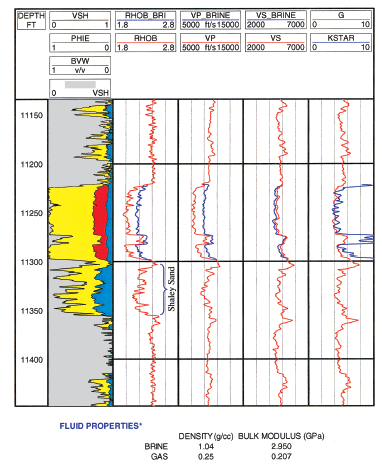

In [2]:
Image(filename='fig5_smith_2003_gassmann.png', width=400)

In [3]:
#vp, vs, rho - from figure 7, the velocities were converted to m/s
shale = [3030,1491,2.41]
sandgas = [2489,1462,2.08]

#### The properties will generate the logs

In [4]:
vp1 = np.zeros(100) + shale[0] 
vs1 = np.zeros(100) + shale[1]
rho1 = np.zeros(100) + shale[2] 
vp2 = np.zeros(100) + sandgas[0]
vs2 = np.zeros(100) + sandgas[1] 
rho2 = np.zeros(100) + sandgas[2] 

vp=np.concatenate((vp1,vp2,vp1))
vs=np.concatenate((vs1,vs2,vs1))
rho=np.concatenate((rho1,rho2,rho1))

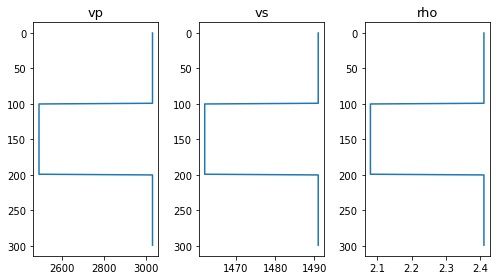

In [5]:
fig=plt.figure(figsize=(7,4))

ax=plt.subplot(1,3,1)
plt.title('vp',fontsize=13)
plt.plot(vp,np.arange(vp.shape[0]))
ax.invert_yaxis()

ax=plt.subplot(1,3,2)
plt.title('vs',fontsize=13)
plt.plot(vs,np.arange(vs.shape[0]))
ax.invert_yaxis()

ax=plt.subplot(1,3,3)
plt.title('rho',fontsize=13)
plt.plot(rho,np.arange(rho.shape[0]))
ax.invert_yaxis()

plt.tight_layout()

#### pre Gassmann

In [6]:
vp_in=sandgas[0]/1000 #vel to km/s
vs_in=sandgas[1]/1000 #vel to km/s
rho_in=sandgas[2]

phi=0.25 #assumed looking at figure 8
#gas density & bulk modulus - from figure 5
rho_f1, k_f1=0.25,0.207
#brine density & bulk modulus - from figure 5
rho_f2, k_f2=1.04,2.95
k0=37 # from table 1 - assuming that is quartz

#### Gassmann - steps from Avseth et. al (2010)

In [7]:
# step1 
k_sat1=rho_in*(vp_in**2-(4/3)*vs_in**2)
mu1=rho_in*vs_in**2
#step2 - equation 12 for kdry (Smith et al., 2003) and eq 1 for the new k_sat2 
kdry= (k_sat1 * ((phi*k0)/k_f1+1-phi)-k0) / ((phi*k0)/k_f1+(k_sat1/k0)-1-phi)
k_sat2 = kdry + (1- (kdry/k0))**2 / ( (phi/k_f2) + ((1-phi)/k0) - (kdry/k0**2) )
#step 3 - mu1=mu2
mu2=mu1
#step4 - new density
rho_out=rho_in+phi*(rho_f2-rho_f1)
#step 5 - new velocities
vp_out=np.sqrt((k_sat2+(4/3)*mu2)/rho_out)*1000 #to km
vs_out=np.sqrt(mu2/rho_out)*1000 #to km

#### The properties will generate the logs

In [8]:
vp1 = np.zeros(100) + shale[0] 
vs1 = np.zeros(100) + shale[1]
rho1 = np.zeros(100) + shale[2] 
vp2 = np.zeros(100) + vp_out
vs2 = np.zeros(100) + vs_out
rho2 = np.zeros(100) + rho_out 

vp2=np.concatenate((vp1,vp2,vp1))
vs2=np.concatenate((vs1,vs2,vs1))
rho2=np.concatenate((rho1,rho2,rho1))

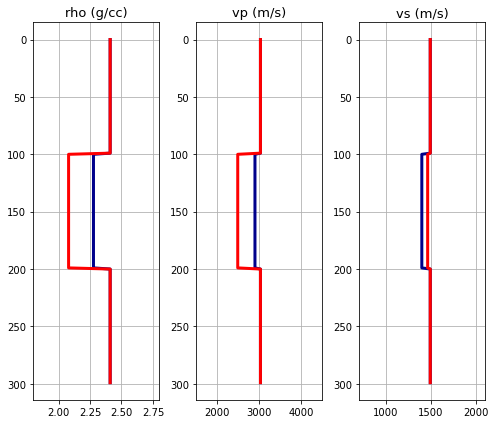

In [9]:
fig=plt.figure(figsize=(7,6))

ax=plt.subplot(1,3,1)
plt.title('rho (g/cc)',fontsize=13)
plt.plot(rho2,np.arange(rho.shape[0]),color='darkblue',linewidth=3)
plt.plot(rho,np.arange(rho.shape[0]),color='red',linewidth=3)
ax.set_xlim(1.8,2.8)
ax.invert_yaxis()
plt.grid()

ax=plt.subplot(1,3,2)
plt.title('vp (m/s)',fontsize=13)
plt.plot(vp2,np.arange(vp.shape[0]),color='darkblue',linewidth=3)
plt.plot(vp,np.arange(vp.shape[0]),color='red',linewidth=3)
ax.set_xlim(1500,4500)
ax.invert_yaxis()
plt.grid()

ax=plt.subplot(1,3,3)
plt.title('vs (m/s)',fontsize=13)
plt.plot(vs2,np.arange(vs.shape[0]),color='darkblue',linewidth=3)
plt.plot(vs,np.arange(vs.shape[0]),color='red',linewidth=3)
ax.set_xlim(700,2100)
ax.invert_yaxis()
plt.grid()

plt.tight_layout()

#### Figure 8

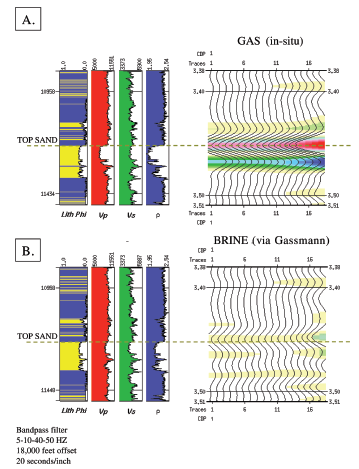

In [10]:
Image(filename='fig8_smith_2003_gassmann.png', width=400)

#### Compute and plot the reflectivity, wavelet, normal incidence offset gather and angle gather. 

In [11]:
angle = np.arange(0,61,1)
anglegather=np.zeros((len(vp),len(angle)))
anglegather2=np.zeros((len(vp),len(angle)))
#define the ricker wavelet
freq=25
length = 0.150
dt = 0.001
time,wavelet=avo.rickerwave(freq, length, dt)

#reflectivity on a interface
_,reflect,r0,g=avo.shueyrc(vp,vs,rho,angle)
_,reflect2,r02,g2=avo.shueyrc(vp2,vs2,rho2,angle)
#generate the angle gather for the input data
gather=[]
for j in range(len(angle)):
    gather.append(np.convolve(wavelet,reflect[:,j],mode='same'))
anglegather=np.asarray(gather).T

#generate the angle gather for the substituted data
gather=[]
for j in range(len(angle)):
    gather.append(np.convolve(wavelet,reflect2[:,j],mode='same'))
anglegather2=np.asarray(gather).T

time2=np.arange(0,(len(vp))*dt,dt)

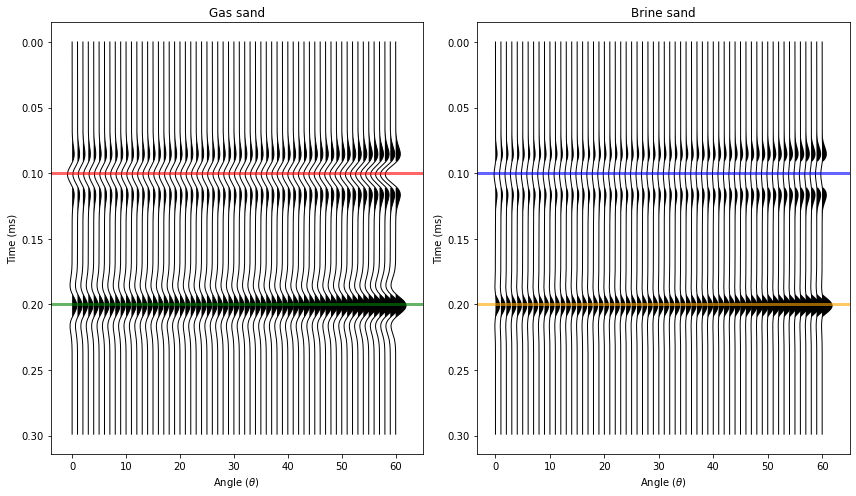

In [12]:
np.warnings.filterwarnings('ignore')
scale_factor=5. #this is scalable according to the plot
anglegatherplt=anglegather*scale_factor #just for the plot
anglegatherplt2=anglegather2*scale_factor #just for the plot

f, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,7))
for i in range(len(angle)):
    ax[0].plot(i+anglegatherplt[:,i],time2,'k',linewidth=1)
    ax[0].fill_betweenx(time2,anglegatherplt[:,i]+i,i,
                        where=anglegatherplt[:,i]+i>i,facecolor='black')
ax[0].invert_yaxis()
ax[0].axhline(y=0.1,color='red',lw=3,alpha=0.6)
ax[0].axhline(y=0.2,color='green',lw=3,alpha=0.6)
ax[0].set_xlabel('Angle ($\\theta$)')
ax[0].set_ylabel('Time (ms)')
ax[0].set_title('Gas sand')

for i in range(len(angle)):
    ax[1].plot(i+anglegatherplt2[:,i],time2,'k',linewidth=1)
    ax[1].fill_betweenx(time2,anglegatherplt[:,i]+i,i,
                        where=anglegatherplt[:,i]+i>i,facecolor='black')
ax[1].invert_yaxis()
ax[1].axhline(y=0.1,color='blue',lw=3,alpha=0.6)
ax[1].axhline(y=0.2,color='orange',lw=3,alpha=0.6)
ax[1].set_xlabel('Angle ($\\theta$)')
ax[1].set_ylabel('Time (ms)')
ax[1].set_title('Brine sand')

plt.tight_layout()

#### AVO with Shuey 3-term

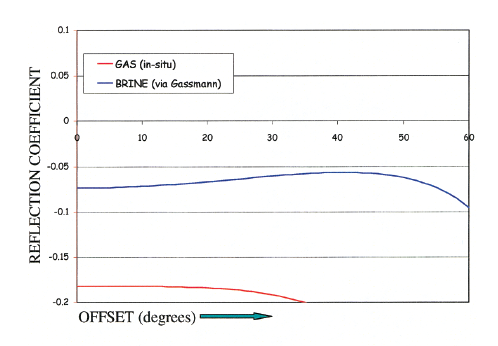

In [13]:
Image(filename='fig7_smith_2003_gassmann.png', width=400)

In [14]:
#top and base of gas
I_tg,G_tg,_,shuey_tg = avo.shuey(vp[99],vs[99],rho[99],vp[100],vs[100],rho[100],angle)
I_bg,G_bg,_,shuey_bg = avo.shuey(vp[199],vs[199],rho[199],vp[200],vs[200],rho[200],angle)

#top and base of brine
I_tb,G_tb,_,shuey_tb = avo.shuey(vp2[99],vs2[99],rho2[99],vp2[100],vs2[100],rho2[100],angle)
I_bb,G_bb,_,shuey_bb = avo.shuey(vp2[199],vs2[199],rho2[199],vp2[200],vs2[200],rho2[200],angle)

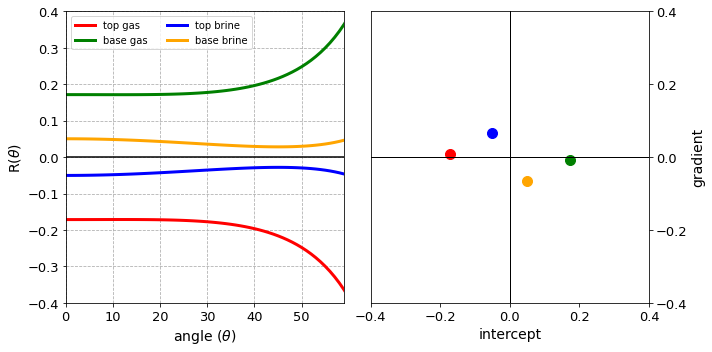

In [15]:
mxplot=0.4

f, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))

ax[0].plot(angle,shuey_tg,'-',color='red',linewidth=3,label='top gas')
ax[0].plot(angle,shuey_bg,'-',color='green',linewidth=3,label='base gas')
ax[0].plot(angle,shuey_tb,'-',color='blue',linewidth=3,label='top brine')
ax[0].plot(angle,shuey_bb,'-',color='orange',linewidth=3,label='base brine')
ax[0].axhline(0, color='k')
ax[0].set_xlabel('angle ($\\theta$)', fontsize=14)
ax[0].set_ylabel('R($\\theta$)', fontsize=14)
yt=np.linspace(-mxplot,mxplot,6)
ax[0].set_yticks(yt)
ax[0].set_xlim(0.,np.max(angle-1))
ax[0].set_ylim(-mxplot,mxplot)
ax[0].tick_params(labelsize=13)
ax[0].grid(linestyle='--')
ax[0].legend(ncol=2)
ax[0].set_yticks(np.linspace(-0.4,0.4,9))

ax[1].plot(I_tg,G_tg,'o',color='red',markersize=10)
ax[1].plot(I_bg,G_bg,'o',color='green',markersize=10)
ax[1].plot(I_tb,G_tb,'o',color='blue',markersize=10)
ax[1].plot(I_bb,G_bb,'o',color='orange',markersize=10)
ax[1].axhline(0, color='k', lw=1)
ax[1].axvline(0, color='k', lw=1)
ax[1].set_xlabel('intercept', fontsize=14)
ax[1].set_ylabel('gradient', fontsize=14)
ax[1].set_xlim(-mxplot,mxplot)
ax[1].set_ylim(-mxplot,mxplot)
yt=np.linspace(-mxplot,mxplot,6)
xt=np.linspace(-mxplot,mxplot,6)
ax[1].set_yticks(yt)
ax[1].set_xticks(xt)
ax[1].xaxis.set_label_position('bottom')
ax[1].xaxis.tick_bottom()
ax[1].yaxis.set_label_position('right')
ax[1].yaxis.tick_right()
ax[1].tick_params(labelsize=13)
ax[1].set_yticks(np.linspace(-0.4,0.4,5))
ax[1].set_xticks(np.linspace(-0.4,0.4,5))

plt.tight_layout()

#### ----------------------------------------- EXTRA CONTENT ----------------------------------------- 


#### VP/VS, AI, NEI, LRM

In [16]:
angle = 41

vpvs=vp/vs
#poisson ratio
pr=0.5*((vpvs**2-2)/(vpvs**2-1))

ai=ip.ai(vp,rho) # acoustic impedance
nei=ip.nei(vp,vs,rho,shale[0],shale[1],shale[2],angle) # normalized elastic impedance
lambda_rho,mu_rho=ip.lrm(vp,vs,rho) # lambda rho and mu rho

vpvs2=vp2/vs2
#poisson ratio
pr2=0.5*((vpvs2**2-2)/(vpvs2**2-1))

ai2=ip.ai(vp2,rho2) # acoustic impedance
nei2=ip.nei(vp2,vs2,rho2,shale[0],shale[1],shale[2],angle) # normalized elastic impedance
lambda_rho2,mu_rho2=ip.lrm(vp2,vs2,rho2) # lambda rho and mu rho

#### Plot the logs - gas sands are in red

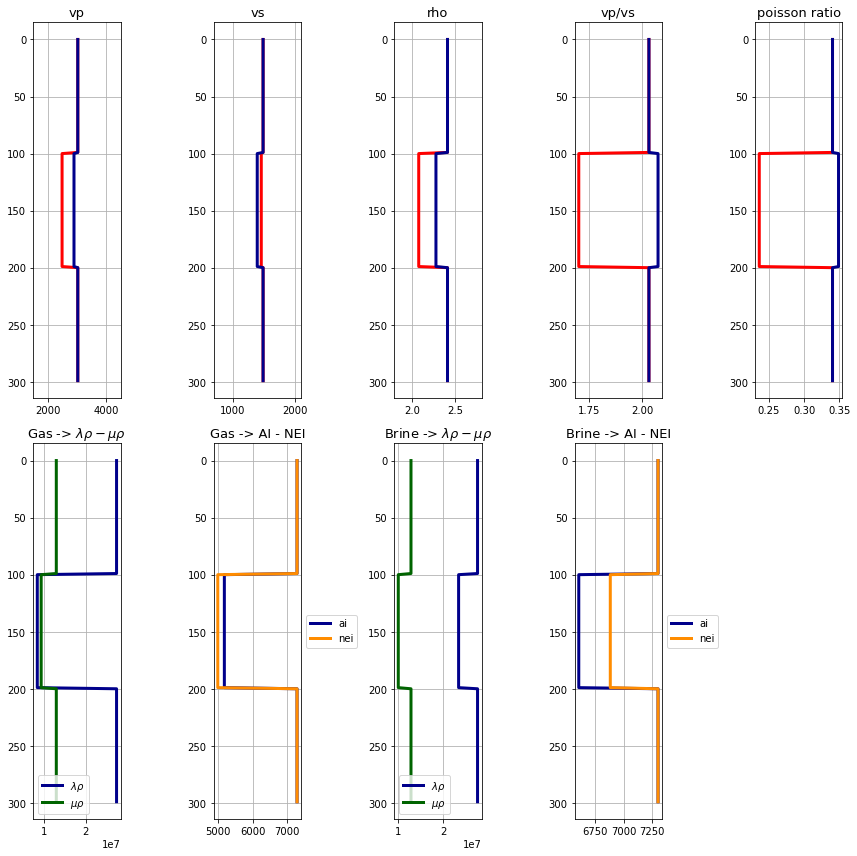

In [17]:
fig=plt.figure(figsize=(12,12))

ax=plt.subplot(2,5,1)
plt.title('vp',fontsize=13)
plt.plot(vp,np.arange(vp.shape[0]),color='red',linewidth=3)
plt.plot(vp2,np.arange(vp.shape[0]),color='darkblue',linewidth=3)
ax.invert_yaxis()
ax.set_xlim(1500,4500)
plt.grid(True)

ax=plt.subplot(2,5,2)
plt.title('vs',fontsize=13)
plt.plot(vs,np.arange(vs.shape[0]),color='red',linewidth=3)
plt.plot(vs2,np.arange(vs.shape[0]),color='darkblue',linewidth=3)
ax.invert_yaxis()
ax.set_xlim(700,2100)
plt.grid(True)

ax=plt.subplot(2,5,3)
plt.title('rho',fontsize=13)
plt.plot(rho,np.arange(rho.shape[0]),color='red',linewidth=3)
plt.plot(rho2,np.arange(rho.shape[0]),color='darkblue',linewidth=3)
ax.invert_yaxis()
ax.set_xlim(1.8,2.8)
plt.grid(True)

ax=plt.subplot(2,5,4)
plt.title('vp/vs',fontsize=13)
plt.plot(vpvs,np.arange(vpvs.shape[0]),color='red',linewidth=3)
plt.plot(vpvs2,np.arange(vpvs.shape[0]),color='darkblue',linewidth=3)
ax.invert_yaxis()
plt.grid(True)

ax=plt.subplot(2,5,5)
plt.title('poisson ratio',fontsize=13)
plt.plot(pr,np.arange(pr.shape[0]),color='red',linewidth=3)
plt.plot(pr2,np.arange(pr.shape[0]),color='darkblue',linewidth=3)
ax.invert_yaxis()
plt.grid(True)

ax=plt.subplot(2,5,6)
plt.title(r'Gas -> $\lambda\rho - \mu\rho$',fontsize=13)
plt.plot(lambda_rho,np.arange(lambda_rho.shape[0]),label=r'$\lambda\rho$',color='darkblue',linewidth=3)
plt.plot(mu_rho,np.arange(mu_rho.shape[0]),label=r'$\mu\rho$',color='darkgreen',linewidth=3)
ax.invert_yaxis()
plt.legend(loc='lower left')
plt.grid(True)

ax=plt.subplot(2,5,7)
plt.title('Gas -> AI - NEI',fontsize=13)
plt.plot(ai,np.arange(ai.shape[0]),label='ai',color='darkblue',linewidth=3)
plt.plot(nei,np.arange(nei.shape[0]),label='nei',color='darkorange',linewidth=3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.invert_yaxis()
plt.grid(True)

ax=plt.subplot(2,5,8)
plt.title(r'Brine -> $\lambda\rho - \mu\rho$',fontsize=13)
plt.plot(lambda_rho2,np.arange(lambda_rho.shape[0]),label=r'$\lambda\rho$',color='darkblue',linewidth=3)
plt.plot(mu_rho2,np.arange(mu_rho.shape[0]),label=r'$\mu\rho$',color='darkgreen',linewidth=3)
ax.invert_yaxis()
plt.legend(loc='lower left')
plt.grid(True)

ax=plt.subplot(2,5,9)
plt.title('Brine -> AI - NEI',fontsize=13)
plt.plot(ai2,np.arange(ai.shape[0]),label='ai',color='darkblue',linewidth=3)
plt.plot(nei2,np.arange(nei.shape[0]),label='nei',color='darkorange',linewidth=3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.invert_yaxis()
plt.grid(True)

plt.tight_layout()

### References:

Avseth, P., Mukerji, T., & Mavko, G., 2010. Quantitative seismic interpretation: Applying rock physics tools to reduce interpretation risk. Cambridge university press.

Tad M. Smith, Carl H. Sondergeld, and Chandra S. Rai, (2003), "Gassmann fluid substitutions: A tutorial," GEOPHYSICS 68: 430-440. 

